Code based on exercises from:

<em>**Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python**</em><br>
<em>Sebastian Raschka, Yuxi (Hayden) Liu and Vahid Mirjalili</em><br>
Packt Publishing (February 25, 2022)



Chapt 11: Implementing a Multilayer Artificial Neural Network from Scratch

In [412]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch as torch
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torchvision as torchvision
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Helper functions. Sigmoidal activation function and a onehot array creator

In [120]:
# sigmoidal activation function
def sigmoid(z):
  return 1./ (1.+np.exp(-z))

# make a one hot array
def intToOnehot(y, nLabels):
  # create a matrix with as many rows as there are
  # y values and as many columns as numLabels
  onehot = np.zeros((y.shape[0],nLabels));
  # for each of the y-values passed in
  for i,val in enumerate(y):
    # set the appropriate onehot vector
    onehot[i,val] = 1
  return onehot

Class for multilayer perceptron.

Following the description in Chapter 11. The following diagram shows the equations (here they split out for each individual node, below have the vectorized equations for all nodes)

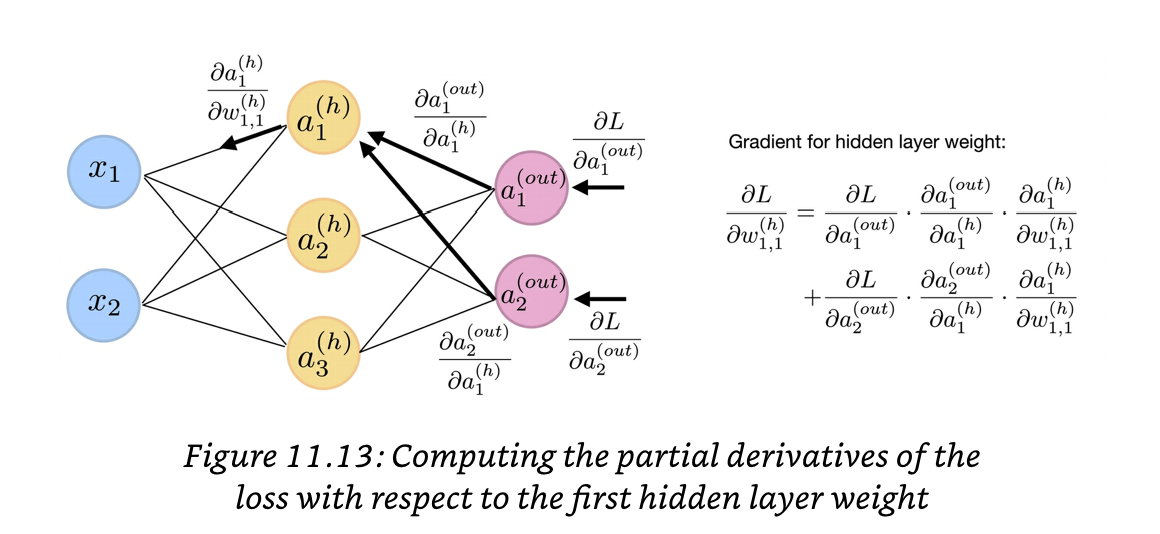


Equations to compute the activation of the hidden layer<br>
$Z^{hidden} = X^{Input}W^{hidden\ T} + b^{hidden}$<br>
$A^{hidden} = \sigma(Z^{hidden})$
<br><br>
Equations to compute the activation of the output layer<br>
$Z^{output} = A^{hidden}W^{output\ T} + b^{output}$<br>
$A^{output} = \sigma(Z^{output})$

We use the Mean Squared Error loss function over the batch of images:<br>
$L(W,b)=\frac{1}{nExamples}\Sigma_{iExample}^{nExample}\frac{1}{nClasses}\Sigma_{iClass}^{nClasses}(y_{iClass}^{iExample} - a_{iClass}^{output\ iExample})^2$

Where the W and b are matrices that include the weights and bias for both the hidden and output layers. That is, the equation averages the loss across all the example images in the batch.
<br><br>
To compute the gradient, with respect to the output weights, we use the chain rule:<br>
$\frac{\delta L}{\delta W^{output}}=\frac{\delta L}{\delta A^{output}}\frac{\delta A^{output}}{\delta Z^{output}}\frac{\delta Z^{output}}{\delta W^{output}}$
<br><br>
Where:
<br><br>
$\frac{\delta L}{\delta A^{output}}=\frac{\delta}{\delta A^{output}}(Y-A^{output})^2=-2(Y-A^{output})$Note that averaging over the batch, this term gets divided by $\frac{1}{nExamples}$<br><br>
$\frac{\delta A^{output}}{\delta Z^{output}}=\frac{\delta}{\delta Z^{output}}=\frac{1}{1+e^{z^{output}}}=A^{output}(1-A^{output})$ See [here](https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e) for derivation.<br><br>
$\frac{\delta Z^{output}}{\delta W^{output}}=\frac{\delta}{\delta W^{output}}A^{hidden}W^{output\ T} + b^{output}=A^{hidden}$<br><br>
For the bias of the output layer, the derivative according to the chain rule is:
<br><br>
$\frac{\delta L}{\delta W^{output}}=\frac{\delta L}{\delta A^{output}}\frac{\delta A^{output}}{\delta Z^{output}}\frac{\delta Z^{output}}{\delta B^{output}}$
<br><br>
Which is exactly the same as for the weights, except that $\frac{\delta Z^{output}}{\delta B^{output}}=1$
<br><br>
To compute the gradient, with respect to the hidden weights, the gradient is:<br><br>
$\frac{\delta L}{\delta W^{hidden}}=\frac{\delta L}{\delta A^{output}}\frac{\delta A^{output}}{\delta Z^{output}}\frac{\delta Z^{output}}{\delta A^{hidden}}\frac{\delta A^{hidden}}{\delta Z^{hidden}}\frac{\delta Z^{hidden}}{\delta W^{hidden}}$<br><br>
The first two terms of these are the same from above where the gradient with respect to the output weights was calculated, that part is what is being back-propagated. Call that:<br><br>
$\delta^{output}=\frac{\delta L}{\delta A^{output}}\frac{\delta A^{output}}{\delta Z^{output}}$<br><br>
The rest of the terms of the gradient for the hidden layer are similar to the ones for the output layer and can be calculated in a similar fashion:<br><br>
$\frac{\delta Z^{output}}{\delta A^{hidden}}=\frac{\delta}{\delta A^{hidden}}A^{hidden}W^{output\ T} + b^{output}=W^{output\ T}$<br><br>

$\frac{\delta A^{hidden}}{\delta Z^{hidden}}=\frac{\delta}{\delta Z^{hidden}}=\frac{1}{1+e^{z^{hidden}}}=A^{hidden}(1-A^{hidden})$<br><br>

$\frac{\delta Z^{hidden}}{\delta W^{hidden}}=\frac{\delta}{\delta W^{hidden}}X^{input}W^{hidden\ T} + b^{hidden}=X^{input}$<br><br>







In [182]:
class mlp:

  # class init function
  def __init__(self, nFeatures, nHidden, nClasses, randomSeed=123):

    # init base class
    super().__init__()
    
    # start the random number generator with the correct seed
    rng = np.random.RandomState(randomSeed)

    # set number of classes
    self.nClasses = nClasses;
    
    # create hidden layer weights and bias
    self.hiddenWeight = rng.normal(loc=0.0, scale=0.1, size=(nHidden, nFeatures))
    self.hiddenBias = np.zeros(nHidden)
    
    # create output weights and bias
    self.outputWeight = rng.normal(loc=0.0, scale=0.1, size=(nClasses,nHidden))
    self.outputBias = np.zeros(nClasses)

  # forward
  def forward(self, x):
    
    # multiply input by hiddenWeights and add bias
    z = np.dot(x,self.hiddenWeight.T) + self.hiddenBias
    
    # apply sigmoid activation function
    hiddenActivation = sigmoid(z)
    
    # multiply hidden activation by output weights and add bias
    z = np.dot(hiddenActivation,self.outputWeight.T) + self.outputBias
    
    # apply sigmoid activation function
    outputActivation = sigmoid(z);
    
    # return
    return hiddenActivation, outputActivation

  # backward
  def backward(self, x, hiddenActivation, outputActivation, y):
    
    # get onehot encoding of outputs
    yOneshot = intToOnehot(y, self.nClasses)
    
    # compute derivative for weights of output layer
    # First, get the derivative of the Loss with respect to the ouptut activations
    # This uses the MeanSquaredError loss, so the derivative is -2 * residual
    # This is computed as the average across exemplars in the batch, so thus we need
    # to divide by the number of exemplars.
    dLoss_dOutputActivation = -2.*(yOneshot - outputActivation) / y.shape[0]
    
    # next compute the derivative of the output activation with resepct to Z
    # this is the derivative of the sigmoid function, which turns out to be
    # very simple (activation * (1-activation)):
    dOutputActivation_dZ = outputActivation * (1. - outputActivation)
    
    # multiply the two derivatives above and save for later use. This is 
    # the part that is being back-propagated
    deltaOutput = dLoss_dOutputActivation * dOutputActivation_dZ
    
    # next part of the derivative is just the hidden activation
    # because Z = weights * activation + bias, so the derivative
    # is just the activation.
    dZ_dOutputWeight = hiddenActivation;
    
    # ok, now that we have all the pieces of the chain-rule, we can
    # compute the partial derivative with respect to the weights
    # note that the matrix multiplication here does the sum
    # over all of the training examples. deltaOutput.T is a matrix
    # of dimensions nClasses x nExamples and dZ_dOutputWeight is
    # a matrix of dimension nExamples x nHiddenUnits. Thus each
    # row and column and of deltaOutput.T and dZ-dOutputWeight contain
    # gradients for each exemplar and in the matrix multiplication,
    # these get point-wise multiplied together and summed.
    dLoss_dOutputWeight = np.dot(deltaOutput.T,dZ_dOutputWeight)

    # same goes for the bias, note that the sum here must be
    # because they are summing over the batch
    dLoss_dOutputBias = np.sum(deltaOutput, axis=0)

    # compute derivate for weights of hidden layer, similarly to those
    # for the output
    dZOutput_dHiddenActivation = self.outputWeight;
    dHiddenActivation_dZHidden = hiddenActivation * (1. - hiddenActivation)
    dZHidden_dWHidden = x;
    
    # use the back-propagated part to get dLoss with respect to the hidden activations
    dLoss_dHiddenActivation = np.dot(deltaOutput,dZOutput_dHiddenActivation);
    
    # Put all the pieces of the chain rule together here.
    dLoss_dHiddenWeight = np.dot((dLoss_dHiddenActivation * dHiddenActivation_dZHidden).T,dZHidden_dWHidden)
    dLoss_dHiddenBias = np.sum((dLoss_dHiddenActivation * dHiddenActivation_dZHidden),axis=0)
    
    # return
    return (dLoss_dOutputWeight,dLoss_dOutputBias,dLoss_dHiddenWeight,dLoss_dHiddenBias)

Define the mse Loss function and accuracy functions

In [183]:
def mseLoss(y,outputActivation,nClasses=10):
  # make y into a onehot vector
  yOnehot = intToOnehot(y,nLabels=nClasses)
  # compute mean squared error
  return np.mean((yOnehot-outputActivation)**2)

def accuracy(y,predictedLabels):
  # calculate average accuracy
  return np.mean(predictedLabels == y)

def computeAccuracyAndMSE(model,x,y):
  # get model forward pass
  _,outputActivation = model.forward(x)
  # get mean squared error
  mse = mseLoss(y,outputActivation)
  # get accuracy
  acc = 100*accuracy(y,np.argmax(outputActivation,axis=1))
  # return the values
  return mse, acc

Test the model, by running the forward and backward pass and returning some stats. 
w/out training, the training accuracy should be near 1/nClasses = 10%

In [184]:
model = mlp(nFeatures=28*28, nHidden=50, nClasses=10)

# test forward pass
hiddenActivation,outputActivation = model.forward(XTrain)

# print stats
print('%ix%i outputActivations, accuracy %0.1f%% mse loss: %0.5f'%((outputActivation.shape[0],outputActivation.shape[1],100*accuracy(yTrain,np.argmax(outputActivation,axis=1)),mseLoss(yTrain,outputActivation))))

# test backward pass
dLoss_dOutputWeight,dLoss_dOutputBias,dLoss_dHiddenWeight,dLoss_dHiddenBias = model.backward(XTrain,hiddenActivation, outputActivation, yTrain)

# pring stats on gradients
print('Gradient for OutputWeight: %0.3f +- %0.3f'%(np.mean(dLoss_dOutputWeight),np.std(dLoss_dOutputWeight)));
print('Gradient for OutputBias: %0.3f +- %0.3f'%(np.mean(dLoss_dOutputBias),np.std(dLoss_dOutputBias)));
print('Gradient for HiddenWeight: %0.3f +- %0.3f'%(np.mean(dLoss_dHiddenWeight),np.std(dLoss_dHiddenWeight)));
print('Gradient for HiddenBias: %0.3f +- %0.3f'%(np.mean(dLoss_dHiddenBias),np.std(dLoss_dHiddenBias)));

60000x10 outputActivations, accuracy 9.1% mse loss: 0.27096
Gradient for OutputWeight: 0.085 +- 0.057
Gradient for OutputBias: 0.199 +- 0.044
Gradient for HiddenWeight: -0.001 +- 0.006
Gradient for HiddenBias: 0.001 +- 0.007


Now load the MNIST data set and create data loaders for iterating over batchs

In [349]:
# Load MNIST dataset
X, y = fetch_openml('mnist_784',version=1,return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

# normalize X values
X = ((X / 255.) - 0.5) * 2

In [350]:
# size and statistics of data
print('MNIST has %i images of size %i'%(X.shape[0],X.shape[1]))
for i,iDigit in enumerate(np.unique(y)):
  print('%i examples of number %i'%(np.sum(y==iDigit),iDigit))

MNIST has 70000 images of size 784
6903 examples of number 0
7877 examples of number 1
6990 examples of number 2
7141 examples of number 3
6824 examples of number 4
6313 examples of number 5
6876 examples of number 6
7293 examples of number 7
6825 examples of number 8
6958 examples of number 9


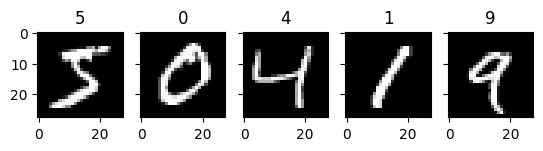

In [351]:
# set up figure
fig, ax = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()
# draw each image
for iImage in range(5):
  # get the image and reshape it back to a 28x28 image
  img = X[iImage][:].reshape(28,28)
  # display the image
  ax[iImage].imshow(img,cmap='gray')
  # show title
  ax[iImage].set_title('%i'%(y[iImage]))

In [188]:
# split into train and test
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size=10000, random_state=123, stratify=y)

# make into TensorDatasets for easier manipulation
trainDataset = TensorDataset(torch.tensor(XTrain),torch.tensor(yTrain))
testDataset = TensorDataset(torch.tensor(XTrain),torch.tensor(yTrain))

# create data loader
batchSize = 100
nEpochs = 50
trainDataLoader = DataLoader(trainDataset,batchSize,shuffle=True);

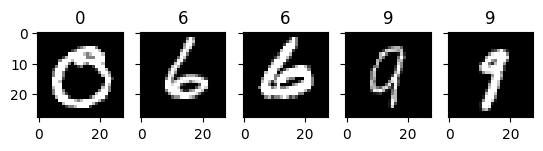

In [189]:
# draw a few examples from a batch to make sure everything is working right
batch = next(iter(trainDataLoader))
# set up figure
fig, ax = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()

for iExample in range(5):
  img = batch[0][iExample].reshape(28,28)
  # display the image
  ax[iExample].imshow(img,cmap='gray')
  ax[iExample].set_title('%i'%(batch[1][iExample]))

make a t-sne visualization of dataset

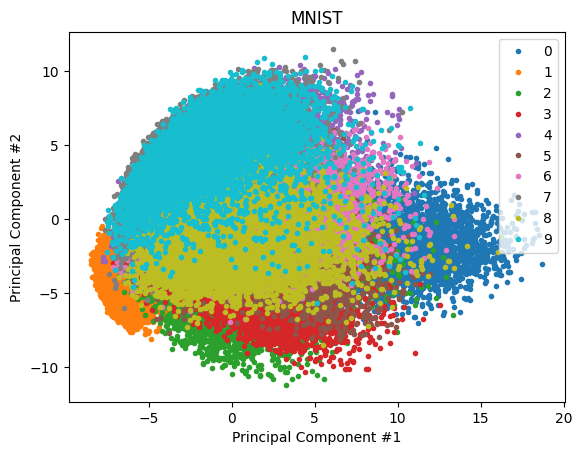

In [423]:
# do a principal components analysis in 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# plot it
for iClass in range(10):
  plt.plot(principalComponents[y==iClass,0],principalComponents[y==iClass,1],'.')

plt.title('MNIST')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.legend(('0','1','2','3','4','5','6','7','8','9'));

In [425]:
# First reduce to 50 principal components
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(X)

# now run TSNE
tsne = TSNE(n_components=2, random_state=0)  # n_components means you mean to plot your dimensional data to 2D
xTSNE = tsne.fit_transform(principalComponents)

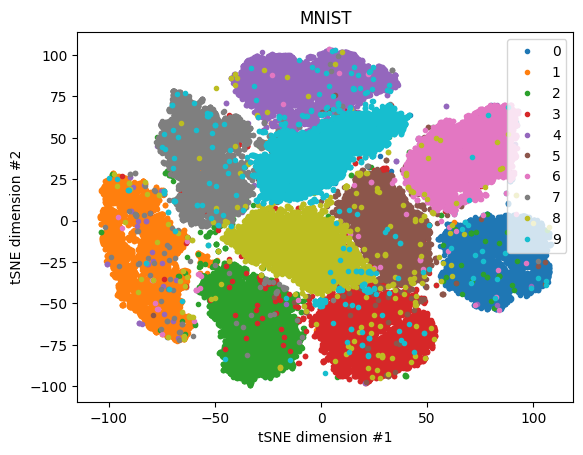

In [426]:
# plot it
for iClass in range(10):
  plt.plot(xTSNE[y==iClass,0],xTSNE[y==iClass,1],'.')

plt.title('MNIST')
plt.xlabel('tSNE dimension #1')
plt.ylabel('tSNE dimension #2')
plt.legend(('0','1','2','3','4','5','6','7','8','9'));

Text(0.5, 1.0, 'Scree Plot for MNIST')

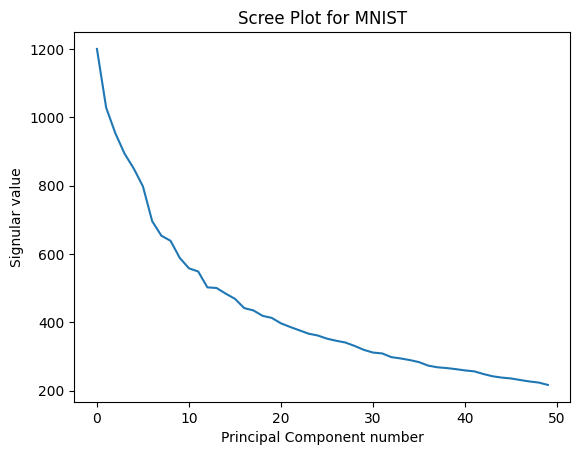

In [430]:
# make scree plot of singular values from PCA
plt.plot(pca.singular_values_)
plt.xlabel('Principal Component number')
plt.ylabel('Signular value')
plt.title('Scree Plot for MNIST')

Train the model. This is done by computing the forward pass to get the activations, then computing the gradients and updating the weights based on those gradients. This is done
using mini-batches

In [302]:
def train(model, X, y, batchSize=100, nEpochs=50, learningRate = 0.1):

  # initialize arrays for holding training progress
  trainMSE = np.zeros(nEpochs);trainAccuracy = np.zeros(nEpochs)
  validationMSE = np.zeros(nEpochs);validationAccuracy = np.zeros(nEpochs)

  # split into train and test
  XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size=10000, random_state=123, stratify=y)

  # make into TensorDatasets for easier manipulation
  trainDataset = TensorDataset(torch.tensor(XTrain),torch.tensor(yTrain))

  # create data loader
  trainDataLoader = DataLoader(trainDataset,batchSize,shuffle=True);

  # iterate over training epochs
  for iEpoch in range(nEpochs):
    
    # compute train and validation accuracy
    trainMSE[iEpoch], trainAccuracy[iEpoch] = computeAccuracyAndMSE(model,XTrain,yTrain)
    validationMSE[iEpoch], validationAccuracy[iEpoch] = computeAccuracyAndMSE(model,XTest,yTest)

    # display update
    print('Epoch %i/%i: train accuracy: %0.1f validation accuracy: %0.1f'%(iEpoch+1,nEpochs,trainAccuracy[iEpoch],validationAccuracy[iEpoch]))

    # iterate over mini-baches
    for iBatch,batch in enumerate(trainDataLoader):
      
      # get the model forward pass
      hiddenActivation,outputActivation = model.forward(batch[0])
      
      # get the gradients
      dLoss_dOutputWeight,dLoss_dOutputBias,dLoss_dHiddenWeight,dLoss_dHiddenBias = model.backward(batch[0],hiddenActivation, outputActivation, batch[1])
      
      # update the weights
      model.outputWeight -= learningRate * dLoss_dOutputWeight
      model.outputBias -= learningRate * dLoss_dOutputBias
      model.hiddenWeight -= learningRate * dLoss_dHiddenWeight
      model.hiddenBias -= learningRate * dLoss_dHiddenBias

  # return training progress
  return trainAccuracy,validationAccuracy,trainMSE,validationMSE

In [388]:
# initialize a model
model = mlp(nFeatures=28*28, nHidden=50, nClasses=10)
# and train the model
trainAccuracy,validationAccuracy,trainMSE,validationMSE = train(model,X,y);

Epoch 1/50: train accuracy: 9.1 validation accuracy: 9.2
Epoch 2/50: train accuracy: 78.3 validation accuracy: 78.2
Epoch 3/50: train accuracy: 86.1 validation accuracy: 85.7
Epoch 4/50: train accuracy: 88.4 validation accuracy: 88.2
Epoch 5/50: train accuracy: 89.6 validation accuracy: 89.5
Epoch 6/50: train accuracy: 90.4 validation accuracy: 90.3
Epoch 7/50: train accuracy: 90.9 validation accuracy: 90.7
Epoch 8/50: train accuracy: 91.3 validation accuracy: 91.3
Epoch 9/50: train accuracy: 91.6 validation accuracy: 91.3
Epoch 10/50: train accuracy: 92.0 validation accuracy: 91.6
Epoch 11/50: train accuracy: 92.2 validation accuracy: 91.9
Epoch 12/50: train accuracy: 92.4 validation accuracy: 91.9
Epoch 13/50: train accuracy: 92.6 validation accuracy: 92.3
Epoch 14/50: train accuracy: 92.8 validation accuracy: 92.2
Epoch 15/50: train accuracy: 93.0 validation accuracy: 92.3
Epoch 16/50: train accuracy: 93.1 validation accuracy: 92.4
Epoch 17/50: train accuracy: 93.3 validation accura

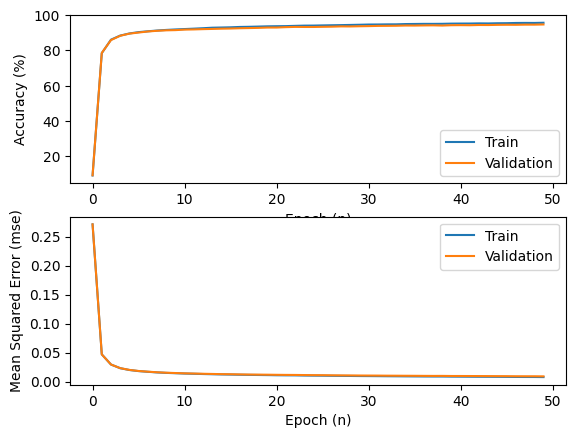

In [198]:
# display the training curves
plt.subplot(2,1,1)
plt.plot(trainAccuracy)
plt.plot(validationAccuracy)
plt.xlabel('Epoch (n)')
plt.ylabel('Accuracy (%)')
plt.legend(('Train','Validation'))

plt.subplot(2,1,2)
plt.plot(trainMSE)
plt.plot(validationMSE)
plt.xlabel('Epoch (n)')
plt.ylabel('Mean Squared Error (mse)')
plt.legend(('Train','Validation'))

Ok, now let's take the easy route and implement this with pytorch 

Chapter 12

In [399]:
class pyTorchModel(nn.Module):
  # init function
  def __init__(self, inputSize, hiddenSize, outputSize):
    # init the base class 
    super().__init__()

    # create the hidden and output layers
    self.hiddenLayer = nn.Linear(inputSize, hiddenSize)
    self.outputLayer = nn.Linear(hiddenSize, outputSize)
    
  def forward(self, x):
    # compute the hidden layer
    x = self.hiddenLayer(x)
    x = nn.Sigmoid()(x)
    # compute the output layer
    x = self.outputLayer(x)
    x = nn.Sigmoid()(x)
    return x

def pyTorchTrain(model, X, y, batchSize=100, nEpochs=50, learningRate = 0.001):
  # start tensorboard writing
  writer = SummaryWriter("runs/mnist")

  # initialize arrays for holding training progress
  trainMSE = np.zeros(nEpochs);trainAccuracy = np.zeros(nEpochs)
  validationMSE = np.zeros(nEpochs);validationAccuracy = np.zeros(nEpochs)

  # turn y into a one hot vector
  yOnehot = intToOnehot(y,nLabels=10);
    
  # split into train and test
  XTrain, XTest, yTrain, yTest = train_test_split(X,yOnehot,test_size=10000, random_state=123, stratify=y)

  # make into TensorDatasets for easier manipulation
  trainDataset = TensorDataset(torch.tensor(XTrain),torch.tensor(yTrain))

  # create data loader
  trainDataLoader = DataLoader(trainDataset,batchSize,shuffle=True);

  # create loss function
  lossFunction = nn.MSELoss(reduction='mean')
    
  # init the optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
  
  # get train and test sets as tensors for evaluating accuracy
  XTrainTensor = torch.tensor(XTrain)
  yTrainTensor = torch.tensor(yTrain)
  XTestTensor = torch.tensor(XTest)
  yTestTensor = torch.tensor(yTest)

  # write model graph  
  writer.add_graph(model,XTrainTensor.float())

  # iterate over training epochs
  for iEpoch in range(nEpochs):
    
    # compute train and validation accuracy
    trainCorrect = 100.0*(torch.argmax(model(XTrainTensor.float()),dim=1)==torch.argmax(yTrainTensor,dim=1)).float().mean()
    testCorrect = 100.0*(torch.argmax(model(XTestTensor.float()),dim=1)==torch.argmax(yTestTensor,dim=1)).float().mean()

    # compute train and validation mse
    trainLoss = lossFunction(model(XTrainTensor.float()),yTrainTensor.float())
    testLoss = lossFunction(model(XTestTensor.float()),yTestTensor.float())

    # write to tensor board
    writer.add_scalar('Training loss',trainLoss,iEpoch)
    writer.add_scalar('Validation loss',testLoss,iEpoch)
    writer.add_scalar('Training accuracy',trainCorrect,iEpoch)
    writer.add_scalar('Validation accuracy',testCorrect,iEpoch)

    # display update
    print('Epoch %i/%i: train accuracy: %0.1f validation accuracy %0.1f'%(iEpoch+1,nEpochs,trainCorrect,testCorrect))

    # iterate over mini-baches
    for xBatch,yBatch in trainDataLoader:
       
      # get the model forward pass
      outputActivation = model(xBatch.float())
      
      # calculate loss
      loss = lossFunction(outputActivation,yBatch.float())

      # reset the gradients
      optimizer.zero_grad()

      # compute gradients
      loss.backward()
    
      # compute the optimization step
      optimizer.step()

  # close tensor board writer
  writer.close()


In [400]:
# initialize model
m = pyTorchModel(inputSize=28*28,hiddenSize=50,outputSize=10)
# and train
pyTorchTrain(m, X, y)

Epoch 1/50: train accuracy: 10.2 validation accuracy 10.2
Epoch 2/50: train accuracy: 82.7 validation accuracy 82.3
Epoch 3/50: train accuracy: 90.4 validation accuracy 90.3
Epoch 4/50: train accuracy: 91.7 validation accuracy 91.4
Epoch 5/50: train accuracy: 92.4 validation accuracy 92.0
Epoch 6/50: train accuracy: 92.8 validation accuracy 92.2
Epoch 7/50: train accuracy: 93.7 validation accuracy 93.0
Epoch 8/50: train accuracy: 94.0 validation accuracy 93.3
Epoch 9/50: train accuracy: 94.5 validation accuracy 93.6
Epoch 10/50: train accuracy: 94.9 validation accuracy 93.8
Epoch 11/50: train accuracy: 95.3 validation accuracy 94.3
Epoch 12/50: train accuracy: 95.5 validation accuracy 94.3
Epoch 13/50: train accuracy: 95.8 validation accuracy 94.6
Epoch 14/50: train accuracy: 96.1 validation accuracy 95.0
Epoch 15/50: train accuracy: 96.0 validation accuracy 94.8
Epoch 16/50: train accuracy: 96.5 validation accuracy 95.1
Epoch 17/50: train accuracy: 96.7 validation accuracy 95.5
Epoch 